In [4]:
%pip install transformers 
%pip install sklearn
%pip install datasets

You should consider upgrading via the '/Users/max/Desktop/Dissertation/implementations/Disso-COLD/proj_env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/max/Desktop/Dissertation/implementations/Disso-COLD/proj_env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/max/Desktop/Dissertation/implementations/Disso-COLD/proj_env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [5]:
import sys
parentdir = "/Users/max/Desktop/Dissertation/implementations/Disso-COLD/"

sys.path.append(parentdir + "/functions")

In [6]:
from transformers import BertForSequenceClassification, BertTokenizer, Trainer, TrainingArguments,DataCollatorWithPadding
from datasets import load_dataset, load_metric,Dataset
import torch
import numpy as np
from datasets import load_dataset
from utils import PrepareCorpus,AssessData
from sklearn.model_selection import train_test_split
from datasets import Dataset,load_dataset
import json
from re import template
from sklearn.model_selection import KFold

/Users/max/Desktop/Dissertation/implementations/Disso-COLD/proj_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
f1_score = load_metric("f1"); precision = load_metric("precision"); recall = load_metric("recall")

bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", truncation = True)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 2)

max_input_length = 300

def tokenize(batch):
    return bert_tokenizer(batch['text'], truncation=True, max_length=max_input_length,padding = True)

def compute_metrics(eval_pred):
    predictions, label = eval_pred
    predictions = np.argmax(predictions, axis = 1)
    return {"f1" :f1_score.compute(predictions = predictions, references = label, average = 'weighted'),
            "precision" : precision.compute(predictions = predictions, references = label, average = 'weighted'),
            "recall": recall.compute(predictions = predictions, references = label, average = 'weighted')}

def hp_space(trial):
  return {"per_device_train_batch_size": trial.suggest_discrete_uniform("per_device_train_batch_size", 8,32,8)
        ,"learning_rate": trial.suggest_float("learning_rate", 0.00001,0.00005, log = True)
        ,"num_train_epochs": trial.suggest_int("num_train_epochs",1,10)}

def bert_init():
  return BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 7)

def id_2_labels(x,adict):
  """converts labels/classes into a number using a dictionary"""
  return adict[x]

def _indexing(alist):
  id = 0; indexed = {}
  for x in alist:
    for y in x:
      id +=1
      indexed[id] = y
  return indexed

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [8]:
imdb = load_dataset("imdb")
imdb

Dataset imdb downloaded and prepared to /Users/max/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


100%|██████████| 3/3 [00:00<00:00, 220.26it/s]


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [9]:
#0 corresponds to negative review while 1 corresponds to positive reviews
label2text = {0:'negative', 1: 'positive'}

train_imdb = imdb['train']
test_imdb = imdb['test']
set(train_imdb['label'])

imdb_train_text = {i:x for i,x in enumerate(train_imdb['text'])}
imdb_test_text = {i:x for i,x in enumerate(test_imdb['text'])}

imdb_train_labels = {i:x for i,x in enumerate(train_imdb['label'])}
imdb_test_labels = {i:x for i,x in enumerate(test_imdb['label'])}

In [ ]:
imdb_train_text.values()

In [10]:
train_imdb_assess = AssessData(imdb_train_text, dict())
test_imdb_assess = AssessData(imdb_test_text, dict())

In [ ]:
train_imdb_assess._create_distribution()
test_imdb_assess._create_distribution()

In [10]:
!pip install nltk
import nltk
nltk.download('punkt')

You should consider upgrading via the '/Users/max/Desktop/Dissertation/implementations/Disso-COLD/proj_env/bin/python3 -m pip install --upgrade pip' command.


[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1131)>


False

{'Too Long': 0, 'Long': 3012, 'BERT': 4759, 'Short': 17229}


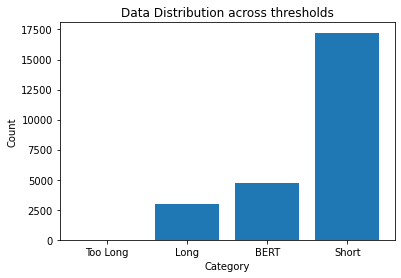

{'Too Long': 0, 'Long': 2803, 'BERT': 4639, 'Short': 17558}


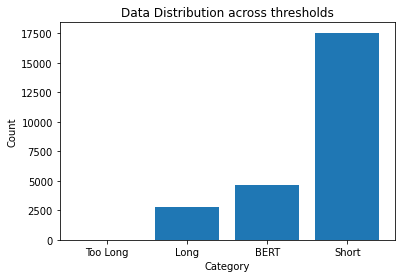

In [11]:
train_imdb_assess._create_distribution()
train_imdb_assess._visualise()

test_imdb_assess._create_distribution()
test_imdb_assess._visualise()

In [11]:
train_set = {"train" : {"text": imdb_train_text.values(), "labels": imdb_train_labels.values(), "id":imdb_train_text.keys()}}
test_set =  {"test" : {"text": imdb_test_text.values(), 'labels': imdb_test_labels.values()}}

In [12]:
import pandas as pd

a = pd.DataFrame(train_set['train'])
b = pd.DataFrame(test_set['test'])

In [14]:
a

,text,labels,id
0,I rented I AM CURIOUS-YELLOW from my video sto...,0,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0,1
2,If only to avoid making this type of film in t...,0,2
3,This film was probably inspired by Godard's Ma...,0,3
4,"Oh, brother...after hearing about this ridicul...",0,4
...,...,...,...
24995,A hit at the time but now better categorised a...,1,24995
24996,I love this movie like no other. Another time ...,1,24996
24997,This film and it's sequel Barry Mckenzie holds...,1,24997
24998,'The Adventures Of Barry McKenzie' started lif...,1,24998


In [13]:
#Modify types
a['text'] = a['text'].astype(str)
a['labels'] = a['labels'].astype(int)

b['text'] = b['text'].astype(str)
b['labels'] = b['labels'].astype(int)

In [14]:
a

,text,labels,id
0,I rented I AM CURIOUS-YELLOW from my video sto...,0,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0,1
2,If only to avoid making this type of film in t...,0,2
3,This film was probably inspired by Godard's Ma...,0,3
4,"Oh, brother...after hearing about this ridicul...",0,4
...,...,...,...
24995,A hit at the time but now better categorised a...,1,24995
24996,I love this movie like no other. Another time ...,1,24996
24997,This film and it's sequel Barry Mckenzie holds...,1,24997
24998,'The Adventures Of Barry McKenzie' started lif...,1,24998


In [15]:
train_set = Dataset.from_pandas(a)
test_set = Dataset.from_pandas(b)

In [16]:
train_set

Dataset({
    features: ['text', 'labels', 'id'],
    num_rows: 25000
})

In [17]:
train_set = train_set.shuffle(seed = 32)
test_set = test_set.add_column("id", imdb_train_text.keys())
#Don't shuffle test

In [22]:
split = train_set.train_test_split(test_size = 0.1)

In [23]:
split_train_set = split['train']
split_valid_set = split['test']

In [22]:
train_set

Dataset({
    features: ['text', 'labels', 'id'],
    num_rows: 25000
})

In [24]:
split_train_set = split_train_set.map(tokenize)
split_valid_set = split_valid_set.map(tokenize)

Parameter 'function'=<function tokenize at 0x296ac5af0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
100%|██████████| 2500/2500 [00:07<00:00, 323.88ex/s]


TRAINING ON FULL DATASET

HYPERPARAMETER TUNING

In [24]:
import sys
parentdir = "/Users/max/Desktop/Dissertation/implementations/Disso-COLD/"

sys.path.append(parentdir + "/models")

In [ ]:
training_args = TrainingArguments(output_dir="IMDB_BERT_no_chunk", learning_rate=5e-5, per_device_train_batch_size=16, per_device_eval_batch_size=16, num_train_epochs=10, weight_decay=0.01)
results = []

data_collator = DataCollatorWithPadding(tokenizer=bert_tokenizer, max_length= 300, padding = True)

#fine-tune
trainer = Trainer(model = model, 
                args = training_args,
                train_dataset= split_train_set,
                eval_dataset= split_valid_set,
                tokenizer= bert_tokenizer,
                data_collator=data_collator,
                compute_metrics= compute_metrics)

trainer.train(resume_from_checkpoint = True)

In [ ]:
trainer.evaluate()

In [28]:
test_set = test_set.map(tokenize)

100%|██████████| 25000/25000 [01:22<00:00, 302.29ex/s]


In [ ]:
predictions = trainer.predict(test_set)

In [ ]:
results = list(np.argmax(predictions.predictions, axis = 1))

In [165]:
orig = {i:x for i,x in zip(test_set['id'], test_set['labels'])}

In [ ]:
pred = {i:x for i,x in zip(test_set['id'], results)}

In [ ]:
incorrect_index = []
for a,b,c in zip(pred.values(), orig.values(), orig.keys()):
  if a != b :
    incorrect_index.append(c)
  else:
    pass

incorrect_index

INVESTIGATING INCORRECT PREDICTIONS

In [134]:
import pickle

with open("incorrect_index_300.pkl", "rb") as ins:
  incorrect_index = pickle.load(ins)

In [163]:
incorrect_index[1]

11

In [167]:
from cmath import nan

def get_pred_result(incorrect_index, orig):
    """gets predicted result from list of incorrect index by changing the original"""
    pred = orig.copy()
    
    for index in incorrect_index:
        pred[index] = nan
 
    for key,value in pred.items():
        a = orig.get(key)
        if value is nan:
            if a == 0:
                pred[key] = 1
            else:
                pred[key] = 0
        else:pass 
    return pred

In [170]:
preds = get_pred_result(incorrect_index, orig)
preds[14514]

0

In [130]:
orig.get(30)

0

In [32]:

def check_wrong_preds(incorrect_index):
  """Checks Wrong predictions, returns incorrect index as a dictionary of ID to"""

  incorrect_labels = [test_set[index] for index in incorrect_index]
  incorrect_index_string_text = {item['id']: item['text'] for item in incorrect_labels}

  incorrect_preds = AssessData(incorrect_index_string_text,dict())
  incorrect_preds._create_distribution()
  incorrect_preds._visualise()

  return incorrect_labels

In [ ]:
#0 stands for negative 1 stands for positive
incorrect_index#Labels here are the original, and the opposite was predicted by the model 

{'Too Long': 0, 'Long': 423, 'BERT': 491, 'Short': 1088}


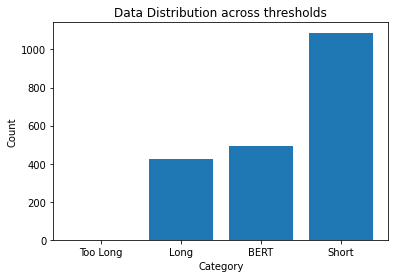

In [135]:
import seaborn as sns
import matplotlib.pyplot as plt 

incorrect_labels_distri = check_wrong_preds(incorrect_index)

(array([ 781.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1221.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

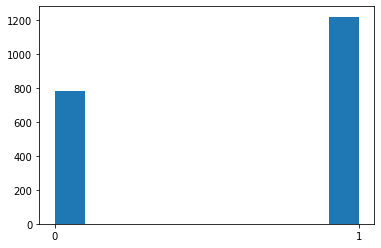

In [123]:
incorrect_labels = [str(x['labels']) for x in incorrect_index]
plt.hist(incorrect_labels)

In [ ]:
test_set['labels']

In [ ]:
preds

{'f1': 0.9184853420195439}


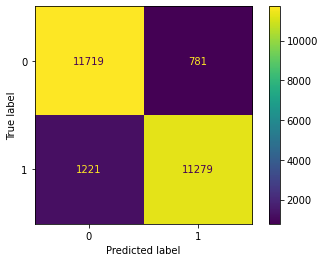

In [172]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(test_set['labels'], list(preds.values()))
f1 = f1_score.compute(predictions = list(preds.values()), references = test_set['labels'])
print(f1)

In [ ]:
#Check index of right and wrong index on local PC
#If there is time, examine the effect of amount of training data on performance

MAXIMUM TOKEN SIZE OF 512

In [ ]:
training_args = TrainingArguments(output_dir="IMDB_BERT_no_chunk", learning_rate=5e-5, per_device_train_batch_size=16, per_device_eval_batch_size=16, num_train_epochs=10, weight_decay=0.01)
results = []

data_collator = DataCollatorWithPadding(tokenizer=bert_tokenizer, max_length= 512, padding = True)

#fine-tune
trainer = Trainer(model = model, 
                args = training_args,
                train_dataset= split_train_set,
                eval_dataset= split_valid_set,
                tokenizer= bert_tokenizer,
                data_collator=data_collator,
                compute_metrics= compute_metrics)

trainer.train()

In [ ]:
trainer.evaluate()

In [ ]:
test_set = test_set.map(tokenize)
predictions = trainer.predict(test_set)
list(predictions.label_ids)

In [ ]:

orig = {i:x for i,x in zip(test_set['id'], test_set['labels'])}
pred = {i:x for i,x in zip(test_set['id'], results)}
orig.values()

In [ ]:
incorrect_index = []
for a,b,c in zip(pred.values(), orig.values(), orig.keys()):
  if a != b :
    incorrect_index.append(c)
  else:
    pass

incorrect_index

INVESTIGATING INCORRECT PREDICTIONS

In [173]:
with open("incorrect_index_512.pkl", "rb") as ins:
    incorrect_index_512 = pickle.load(ins)

with open("results_2_512.pkl", "rb") as ins:
    results_512 = pickle.load(ins)

In [ ]:
len(incorrect_index_512)

1926

{'f1': 0.9228489024194841}


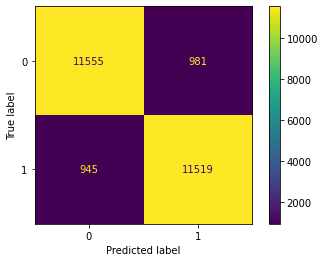

In [178]:
ConfusionMatrixDisplay.from_predictions(results_512, test_set['labels'])
f1 = f1_score.compute(predictions= results_512, references = test_set["labels"])
print(f1)

{'Too Long': 0, 'Long': 401, 'BERT': 449, 'Short': 1076}


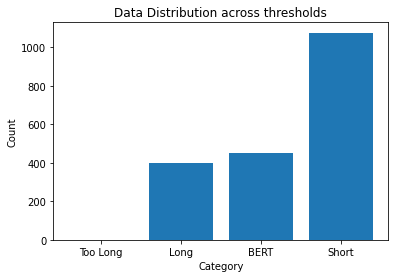

In [ ]:
incorrect_index_512 = check_wrong_preds(incorrect_index_512)

(array([945.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 981.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

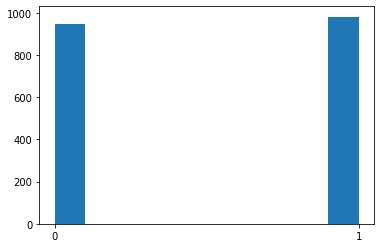

In [ ]:
incorrect_labels_512 = [str(x['labels']) for x in incorrect_index_512]
plt.hist(incorrect_labels_512)

Checking if there's a relationship between bert_300 and bert_512

In [ ]:
intersection = []; different = []

#intersection are entries predicted wrong in BERT max 300 and BERT max 512
#different are new entries right in BERT max 300 but wrong in BERT max 512
for a in incorrect_index_512:
    if a in incorrect_index:
        intersection.append(a)
    if a not in incorrect_index:
        different.append(a)

In [ ]:
len(different) #Labels in dictionaries are the correct labels 

637

{'Too Long': 0, 'Long': 282, 'BERT': 307, 'Short': 700}


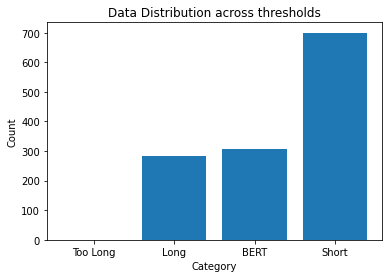

(array([573.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 716.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

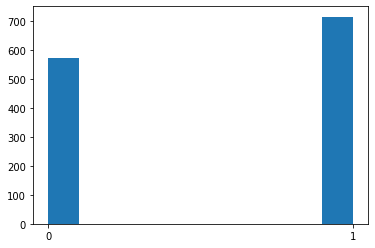

In [ ]:
len(intersection)

#check intersection ones if there's a pattern in distribution
intersection_index_string_text = {item['id']: item['text'] for item in intersection}
intersect = AssessData(intersection_index_string_text,dict())
intersect._create_distribution()
intersect._visualise()

#check plot of classes
intersect_labels= [str(x['labels']) for x in intersection]
plt.hist(intersect_labels)

{'Too Long': 0, 'Long': 119, 'BERT': 142, 'Short': 376}


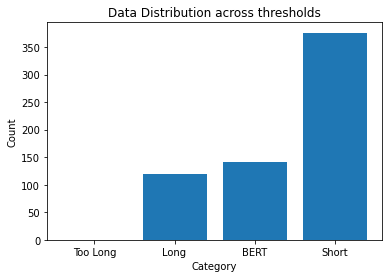

(array([372.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 265.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

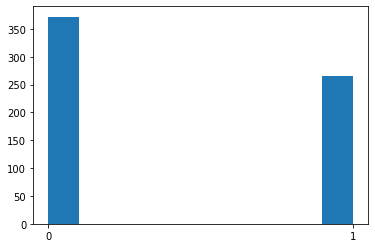

In [ ]:
different_index_string_text = {item['id']: item['text'] for item in different}
different_a = AssessData(different_index_string_text,dict())
different_a._create_distribution()
different_a._visualise()

#check plot of different
different_labels= [str(x['labels']) for x in different]
plt.hist(different_labels)

In [1]:
different_index_string_text

NameError: name 'different_index_string_text' is not defined